#Pandas Express 
###An express guide to becoming a Kung Fu Pandas master

<img src="http://vignette1.wikia.nocookie.net/kungfupanda/images/8/88/Po2.jpg/revision/latest?cb=20100726062228" width="300"/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [4]:
def load_json(json_file):
    
    # Open the JSON file
    with open(json_file) as file:
        data = file.readlines()

    # Remove the trailing "\n" from each line
    data = map(lambda x: x.rstrip(), data)

    # Combine rows into a comma separated JSON array
    formatted_data = "[" + ','.join(data) + "]"

    return formatted_data

In [5]:
data = load_json('data/business.json')

In [6]:
data

In [7]:
business_df = pd.read_json(data)

In [6]:
business_df.head()

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,{u'By Appointment Only': True},vcNAWiLM4dR7D2nwwJ7nCA,"[Doctors, Health & Medical]",Phoenix,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...","{u'Thursday': {u'close': u'17:00', u'open': u'...",33.499313,-111.983758,"Eric Goldberg, MD",[],True,9,3.5,AZ,business
1,"{u'Happy Hour': True, u'Accepts Credit Cards':...",UsFtqoBl7naz8AVUBZMjQQ,[Nightlife],Dravosburg,"202 McClure St\nDravosburg, PA 15034",{},40.350519,-79.886930,Clancy's Pub,[],True,4,3.5,PA,business
2,{u'Good for Kids': True},cE27W9VPgO88Qxe4ol6y_g,"[Active Life, Mini Golf, Golf]",Bethel Park,"1530 Hamilton Rd\nBethel Park, PA 15234",{},40.356896,-80.015910,Cool Springs Golf Center,[],False,5,2.5,PA,business
3,{},HZdLhv6COCleJMo7nPl-RA,"[Shopping, Home Services, Internet Service Pro...",Pittsburgh,"301 S Hills Vlg\nPittsburgh, PA 15241","{u'Monday': {u'close': u'21:00', u'open': u'10...",40.357620,-80.059980,Verizon Wireless,[],True,3,3.5,PA,business
4,"{u'Alcohol': u'full_bar', u'Noise Level': u'av...",mVHrayjG3uZ_RLHkLj-AMg,"[Bars, American (New), Nightlife, Lounges, Res...",Braddock,"414 Hawkins Ave\nBraddock, PA 15104","{u'Tuesday': {u'close': u'19:00', u'open': u'1...",40.408735,-79.866351,Emil's Lounge,[],True,11,4.5,PA,business


In [7]:
business_df.describe()

,latitude,longitude,open,review_count,stars
count,61184.000000,61184.000000,61184,61184.000000,61184.000000
mean,37.326077,-97.491803,0.878089,28.272506,3.673305
std,5.741085,29.624473,0.3271856,88.652050,0.891207
min,32.871923,-115.386550,False,3.000000,1.000000
25%,33.509601,-115.052224,1,4.000000,3.000000
50%,35.994636,-111.932944,1,8.000000,3.500000
75%,36.240430,-80.863329,1,21.000000,4.500000
max,56.036545,8.549249,True,4578.000000,5.000000


In [8]:
business_df['state'].unique()

array([u'AZ', u'PA', u'NC', u'SC', u'WI', u'IL', u'NV', u'WA', u'CA',
       u'QC', u'ON', u'EDH', u'MLN', u'ELN', u'HAM', u'SCB', u'FIF',
       u'XGL', u'NTH', u'BW', u'RP', u'KHL', u'MN', u'MA', u'NW', u'OR'], dtype=object)

In [13]:
business_df[business_df['name'] == 'Panda Express']

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
1816,"{u'Take-out': True, u'Accepts Credit Cards': T...",kMcbuXZx3iILJVEPyLgPpQ,"[Chinese, Restaurants]",Champaign,"2000 N Neil St\nChampaign, IL 61820",{},40.139918,-88.244639,Panda Express,[],True,5,3.5,IL,business
2613,"{u'Take-out': True, u'Price Range': 1, u'Outdo...",nLpV9fo8xml-QHOKyOje2A,"[Chinese, Restaurants]",Phoenix,"3923 E Thomas Rd\nPhoenix, AZ 85018",{},33.479870,-111.997824,Panda Express,[],True,13,2.5,AZ,business
2778,"{u'Take-out': True, u'Accepts Credit Cards': T...",wLZ--5d4lXImxrG7VhdTyA,"[Chinese, Restaurants]",Phoenix,"7000 N 16th St\nSte 100\nPhoenix, AZ 85020",{},33.538927,-112.048079,Panda Express,[],True,11,3.5,AZ,business
2994,"{u'Take-out': True, u'Price Range': 1, u'Outdo...",VTFx4ADDP6nPnlcMHB1-Ow,"[Chinese, Restaurants]",Phoenix,"903 E Bell Rd\nSte 101\nPhoenix, AZ 85022",{},33.640255,-112.061145,Panda Express,[],True,7,4.0,AZ,business
3053,"{u'Take-out': True, u'Price Range': 1, u'Outdo...",bexPpkHMthuCaeC0g0Lrfg,"[Chinese, Restaurants]",Phoenix,"10637 N Tatum Blvd\nPhoenix, AZ 85028","{u'Monday': {u'close': u'21:00', u'open': u'10...",33.584266,-111.976787,Panda Express,[],True,7,3.0,AZ,business
3282,"{u'Take-out': True, u'Price Range': 2, u'Outdo...",rEC1QrZVEYH8LpowJ_DNZA,[Restaurants],Phoenix,"3932 E Thunderbird Rd\nSuite 111\nPhoenix, AZ ...",{},33.611868,-111.996439,Panda Express,[],True,6,4.0,AZ,business
3770,"{u'Take-out': True, u'Price Range': 1, u'Outdo...",4DDbIvNtzfhLRwz-EOLFDA,"[Food, Desserts, Asian Fusion, Chinese, Restau...",Phoenix,"21001 N Tatum Blvd\nSte 1630\nPhoenix, AZ 85050","{u'Monday': {u'close': u'22:30', u'open': u'10...",33.678615,-111.974607,Panda Express,[],True,8,4.0,AZ,business
4033,"{u'Take-out': True, u'Accepts Credit Cards': T...",LjwXnAjusrwCZGsWV3Ue8Q,[Restaurants],Mesa,"3440 E Baseline Road\nMesa, AZ 85204",{},33.379624,-111.755988,Panda Express,[],True,10,2.5,AZ,business
4156,"{u'Take-out': True, u'Takes Reservations': Fal...",iyDeQ21CQO2-eKbbiHzrWg,"[Chinese, Restaurants]",Mesa,"1959 S Power Rd\nMesa, AZ 85206",{},33.380304,-111.688796,Panda Express,[],True,3,2.0,AZ,business
4720,"{u'Take-out': True, u'Good For': {u'dessert': ...",9whGt6zd2ulTYKqRNB02yA,[Restaurants],Chandler,"3111 W Chandler Boulevard\nChandler, AZ 85226",{},33.305681,-111.897553,Panda Express,[],True,3,2.5,AZ,business


In [21]:
business_df['attributes'][5]

{u'Accepts Credit Cards': True,
 u'Alcohol': u'full_bar',
 u'Ambience': {u'casual': True,
  u'classy': False,
  u'divey': False,
  u'hipster': False,
  u'intimate': False,
  u'romantic': False,
  u'touristy': False,
  u'trendy': False,
  u'upscale': False},
 u'Attire': u'casual',
 u'Caters': False,
 u'Coat Check': False,
 u'Delivery': False,
 u'Good For': {u'breakfast': False,
  u'brunch': False,
  u'dessert': False,
  u'dinner': True,
  u'latenight': False,
  u'lunch': False},
 u'Good For Dancing': True,
 u'Good For Groups': True,
 u'Good for Kids': False,
 u'Happy Hour': True,
 u'Has TV': True,
 u'Music': {u'dj': False},
 u'Noise Level': u'loud',
 u'Outdoor Seating': True,
 u'Parking': {u'garage': False,
  u'lot': True,
  u'street': False,
  u'valet': False,
  u'validated': False},
 u'Price Range': 1,
 u'Smoking': u'outdoor',
 u'Take-out': True,
 u'Takes Reservations': False,
 u'Waiter Service': True,
 u'Wi-Fi': u'free'}

###Exploratory Analysis

In [32]:
print "Mean: %f" % business_df['stars'].mean()

Mean: 3.673305


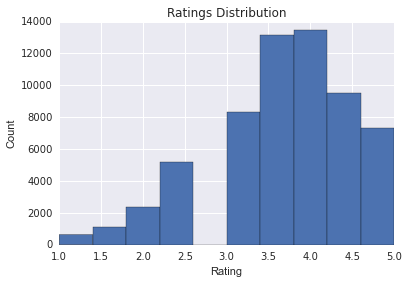

In [40]:
plt.hist(business_df['stars'])
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
business_df.hist(column='stars')
plt.title('Ratings Distribution')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()

In [ ]:
df.boxplot(column='Age', by='review_count')

In [12]:
print "Min: %d" % business_df['review_count'].min()
print "Max: %d" % business_df['review_count'].max()
print "Mean: %f" % business_df['review_count'].mean()

Min: 3
Max: 4578
Mean: 28.272506


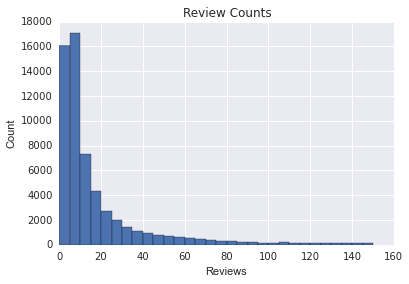

In [41]:
plt.hist(business_df['review_count'], bins=30, range=(0,150))
plt.title('Review Counts')
plt.xlabel('Reviews')
plt.ylabel('Count')
plt.show()